# Finding good comparison stars for our target stars
The following code  downloads photometry from the SkyMapper survey around a specificed RA and DEC and search for good comparison stars for our RR Lyrae target stars.  Right now, it only works on one star at a time, and you neeed to manually enter the RA, DEC and Gaia ID and Gaia Gmag into the code.  You can obviously change this to read in a csv file. <br>
<br>
After the code has found the comparison stars, it currently outputs the number of comparison stars for Mookodi and SHOC, creates a ds9 region file and displays a digitized sky survey image with the target star and comparison stars circled - a finding chart which will be very useful when you are observing.
<br> 
<br>
General information on Skymapper: [https://skymapper.anu.edu.au/about-skymapper/](https://skymapper.anu.edu.au/about-skymapper/)  . This page gives information on the meaning of the various columns: [https://skymapper.anu.edu.au/table-browser/](https://skymapper.anu.edu.au/table-browser/) <br>
<br>
To access the date, we will use TAP (Table Access Protocol), which is a table query based upon standards from the Virtual Observatory.  To access the TAP, we use the pyvo and regions package.  These are not installed by default, so you need to open up a terminal window and type in the following at the command line: <br>
pip install pyvo <br>
pip install regions
<br> 
<br>
The code below creates the TAP query, doing a cone search with a radius of 5.0 arcminutes = 0.083 degrees around the specified RA and DEC of the SkyMapper photometry file.  It specfies which columns to download, and the output is ordered by the distance of the star from the center of the search cone.



In [32]:
import pyvo as vo
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
from regions import CircleSkyRegion
from regions import Regions
from io import BytesIO
import math 
import requests
from astropy.io import fits
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.patches import Rectangle
import matplotlib.text as mpl_text

myra = str(241.549652)
mydec = str(-43.31913896)
my_gaia_id = "5991844282681283712"
Gaia_G = 10.887369



#create the TAP query. Note that the search radius is in degrees, and 0.083 is 5.0 arcminutes
my_tap_query = ("SELECT DISTANCE(POINT('ICRS', raj2000, dej2000), POINT('ICRS', "   
              + myra + ", " + mydec + 
              ")) AS dist, "  + 
              "m.object_id,m.raj2000,m.dej2000,m.g_flags,m.g_nimaflags,m.i_flags,m.i_nimaflags, " + 
            "m.g_psf,m.e_g_psf,m.i_psf,m.e_i_psf  FROM dr4.master AS m " + 
              "WHERE 1 = CONTAINS(POINT('ICRS', raj2000, dej2000), " 
              "CIRCLE('ICRS',"  + 
               myra +", "+ mydec + 
              ", 0.083 )) ORDER BY dist " )
              
#print(my_tap_query)


## Now, exectue the search on the SkyMapper server

In [33]:
tap_service = vo.dal.TAPService("https://api.skymapper.nci.org.au/public/tap/")
tap_results =  tap_service.search(my_tap_query)

The results of the TAP query are saved as a VO table.  Convert to a Pandas dataframe, which is easier to manipulate.

In [34]:
astropy_table = tap_results.to_table()
df = astropy_table.to_pandas()
#df.info()

#make sure that we really have found out target star 
if df['dist'].iloc[0] > 0.00056 :
    print("We have a problem, distance > 2 arcsconds")
    raise SystemExit("Stop right there!")


## Get rid of stars with bad photometry
Keep only stars which havve good photometry in both g and i filters.  Good photometric measuresments  have flags and nimaflags = 0 and photometric errors < 0.05 mag in both the g and i filters. 

In [35]:
g_good1 = df['g_flags'] == 0 
g_good2 = df['g_nimaflags'] == 0
g_good3 = df['e_g_psf'] < 0.05
i_good1 = df['i_flags'] == 0 
i_good2 = df['i_nimaflags'] == 0
i_good3 = df['e_i_psf'] < 0.07

#combine these comparisons to make a new dataframe
# using df_good = df.query('g_flags == 0 ') does not work, as some of the values are null...
df_good = df[g_good1 & g_good2 & g_good3 & i_good1 & i_good2 & i_good3]
num_good = df_good.shape[0]
print("Number of stars with good photometry: ",  num_good)
print(df_good[['dist', 'raj2000', 'dej2000','g_psf','e_g_psf', 'i_psf', 'e_i_psf']])


Number of stars with good photometry:  326
          dist     raj2000    dej2000      g_psf  e_g_psf      i_psf  e_i_psf
8     0.005482  241.542369 -43.317735  16.965500   0.0126  15.334600   0.0083
12    0.006257  241.556220 -43.315100  19.789600   0.0291  18.522600   0.0332
16    0.007344  241.539772 -43.320643  17.150200   0.0144  16.113100   0.0096
27    0.009747  241.561538 -43.323636  17.415600   0.0105  16.427601   0.0101
35    0.010693  241.551843 -43.329712  18.097099   0.0260  16.932800   0.0180
...        ...         ...        ...        ...      ...        ...      ...
2343  0.081795  241.612691 -43.251429  19.718300   0.0449  18.399200   0.0199
2359  0.082126  241.604124 -43.247221  20.021200   0.0497  18.700399   0.0261
2386  0.082609  241.515770 -43.397989  19.703899   0.0177  18.124201   0.0427
2387  0.082616  241.641762 -43.367493  19.090099   0.0434  17.347300   0.0446
2395  0.082780  241.464051 -43.264637  17.741501   0.0153  16.373199   0.0122

[326 rows x 7 column

## Determine which instrument can observe this star

We want comparison stars that are within 4 magnitudes (recall a magnitude = 2.5log(f2/f1) ) of our target star. For now seach for stars which are up to 1.0 mag brighter, or 3.5 mags fainter.  However,some of our target RR Lyrae stars do not have good photometry, in g or i band in SkyMapper.  Hence, we will approximate things and just do a cut on i magnitude, assuming that the stars are 0.5 mag brighter than their Gaia G magnitude.  You can likely do better than the code below, and will want to carefully examine the photometry file above, and the fits file to see if you think a different set of comparision stars would be useful.<br>
<br>

Note that our default search had a radius of 5.0 arcminutes, which corrosponds to the field of view of Mookodi, which is on Lesedi.  SHOC, which is on the 1.0meter telescope has a field of view with 2.85x2.85 arcminuts, so we need to restrict ourselves to stars which are within 1.4 arcminutes of the target star.

In [36]:
i_brightcut = Gaia_G - 1.0
i_faintcut = Gaia_G + 4.5

i_bright = df_good['i_psf'] > i_brightcut
i_faint = df_good['i_psf'] < i_faintcut

df_mookodi = df_good[i_bright & i_faint]



shoc_comp = df_mookodi['dist'] < 0.0233   #SHOC field of view is 2.8x2.8 arcminutes, so use r=1.4 arcminutes
df_shoc = df_mookodi[shoc_comp]
num_mookodi = df_mookodi.shape[0]
num_shoc_comp = df_shoc.shape[0]
if num_mookodi > 1 :
    mookodi = " and Mookodi can observe this star"
else : 
    mookodi = ""

        
print("Number of comparison stars for Mookodi: ", num_mookodi, mookodi )

if num_mookodi > 1 :
    print(df_mookodi[['dist', 'raj2000', 'dej2000','g_psf','e_g_psf', 'i_psf', 'e_i_psf']])


if num_shoc_comp > 1 :
    shoc = " and SHOC can observe this star"
    print("Number of comparison stars for SHOC: ", num_shoc_comp, shoc)
    print(df_shoc[['dist', 'raj2000', 'dej2000','g_psf','e_g_psf', 'i_psf', 'e_i_psf']])


Number of comparison stars for Mookodi:  14  and Mookodi can observe this star
          dist     raj2000    dej2000      g_psf  e_g_psf    i_psf  e_i_psf
8     0.005482  241.542369 -43.317735  16.965500   0.0126  15.3346   0.0083
303   0.029751  241.509230 -43.314645  15.423700   0.0084  14.0004   0.0076
664   0.043492  241.498073 -43.341135  16.440300   0.0115  14.7419   0.0073
854   0.049442  241.539457 -43.368022  16.217300   0.0131  15.2783   0.0121
1116  0.056445  241.481385 -43.292342  16.323000   0.0188  14.6180   0.0142
1264  0.059914  241.612007 -43.358291  16.287399   0.0080  15.2457   0.0078
1284  0.060412  241.619399 -43.286379  16.859100   0.0083  15.3636   0.0079
1380  0.062655  241.627748 -43.345573  15.444300   0.0071  14.6136   0.0079
1426  0.063571  241.618858 -43.357968  12.862000   0.0097  12.1521   0.0090
1611  0.067746  241.549417 -43.251393  16.100901   0.0081  14.4842   0.0079
1619  0.067982  241.543256 -43.251317  14.932000   0.0071  14.1589   0.0069
1994  0.0

## Download an image of the field
We now want to get an image of the field containing our star (which is the first star in df).  We will use the Digitized sky survey, and return an image which is 10x10 arcminutes, so quite a bit bigger than the field of view of our instruments.  This is makes a useful finding chart in case the telescope pointing is not accurate.  
<br>
We query the digitized sky survey using a simple https request, which is made using the python package requests.  Once we get the data, we save it as a fits file, with the name of the file being the Gaia ID of our target star. We put the header of the fits file into *hdr* and the image data into *red_image* 



In [37]:
#https://skyview.gsfc.nasa.gov/cgi-bin/images?Survey=digitized+sky+survey&position=14.5,36.5&Return=FITS
        
my_https_query = ("https://skyview.gsfc.nasa.gov/cgi-bin/images?Survey=digitized+sky+survey&position="
                 + myra + "," + mydec + 
                 "&Size=0.1667&Return=FITS")
#print(my_https_query)


#try using DR3 for the filename
file_name = "DR3_" + str(my_gaia_id) + ".fits"
#print(file_name)

r=requests.get(my_https_query)
with open(file_name, "wb") as f:
    f.write(r.content) 
    
with fits.open(BytesIO(r.content)) as hdul:
   hdr=hdul[0].header
   red_image=hdul[0].data


## Calculate the conversion between  RA,Dec  and pixel values
We will want to circle our stars and show the field of View of SHOC, so need to convert our RA,Dec coordinates into x,y values which we can plot.  The code below throws a warning.  Spend 10 or 15 minutes to see if you can get rid of the warning and still get the results that are intended.  If you can't do so, don't worry about it, as the code does work. 

In [38]:
#print(header)
xlength = hdr['NAXIS1']
xcenpix = hdr['CRPIX1']
racen = hdr['CRVAL1']
rascale = hdr['CDELT1']
ylength = hdr['NAXIS2']
ycenpix = hdr['CRPIX2']
deccen = hdr['CRVAL2']
decscale = hdr['CDELT2']


#print(xlength,xcenpix,rascale,ylength,ycenpix,decscale)

#print(racen, deccen)
decadjust = math.cos(math.radians(deccen) )

#something is not quite right with the two lines below, but I do not understand the warning; using  .loc(:, )
# does not get rid of the warning

df_mookodi['xpix'] = xcenpix - (racen - df_mookodi['raj2000'])/rascale*decadjust
df_mookodi['ypix'] = ycenpix - (deccen - df_mookodi['dej2000'])/decscale
#df_mookodi.loc[:, ('xpix')] = xcenpix + (racen - df_mookodi.loc[:,('raj2000')])/rascale
#print(df_mookodi[['dist', 'raj2000', 'dej2000', 'xpix', 'ypix']] )

#calculate SHOC field of view in pixel coordinates for a rectangle
shoc_x = xcenpix - (1.42/60.0)/rascale*decadjust
shoc_y = ycenpix - (1.42/60.0)/decscale
shoc_width = (2.85/60.0)/rascale*decadjust
shoc_height = (2.85/60.0)/decscale


C:\Users\Aryan Bawa\AppData\Local\Temp\ipykernel_27204\39955869.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mookodi['xpix'] = xcenpix - (racen - df_mookodi['raj2000'])/rascale*decadjust
C:\Users\Aryan Bawa\AppData\Local\Temp\ipykernel_27204\39955869.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mookodi['ypix'] = ycenpix - (deccen - df_mookodi['dej2000'])/decscale


## Plot the fits image
Circle the target and comparison stars, show the SHOC field of view and print the name of the target star at the bottom of the image

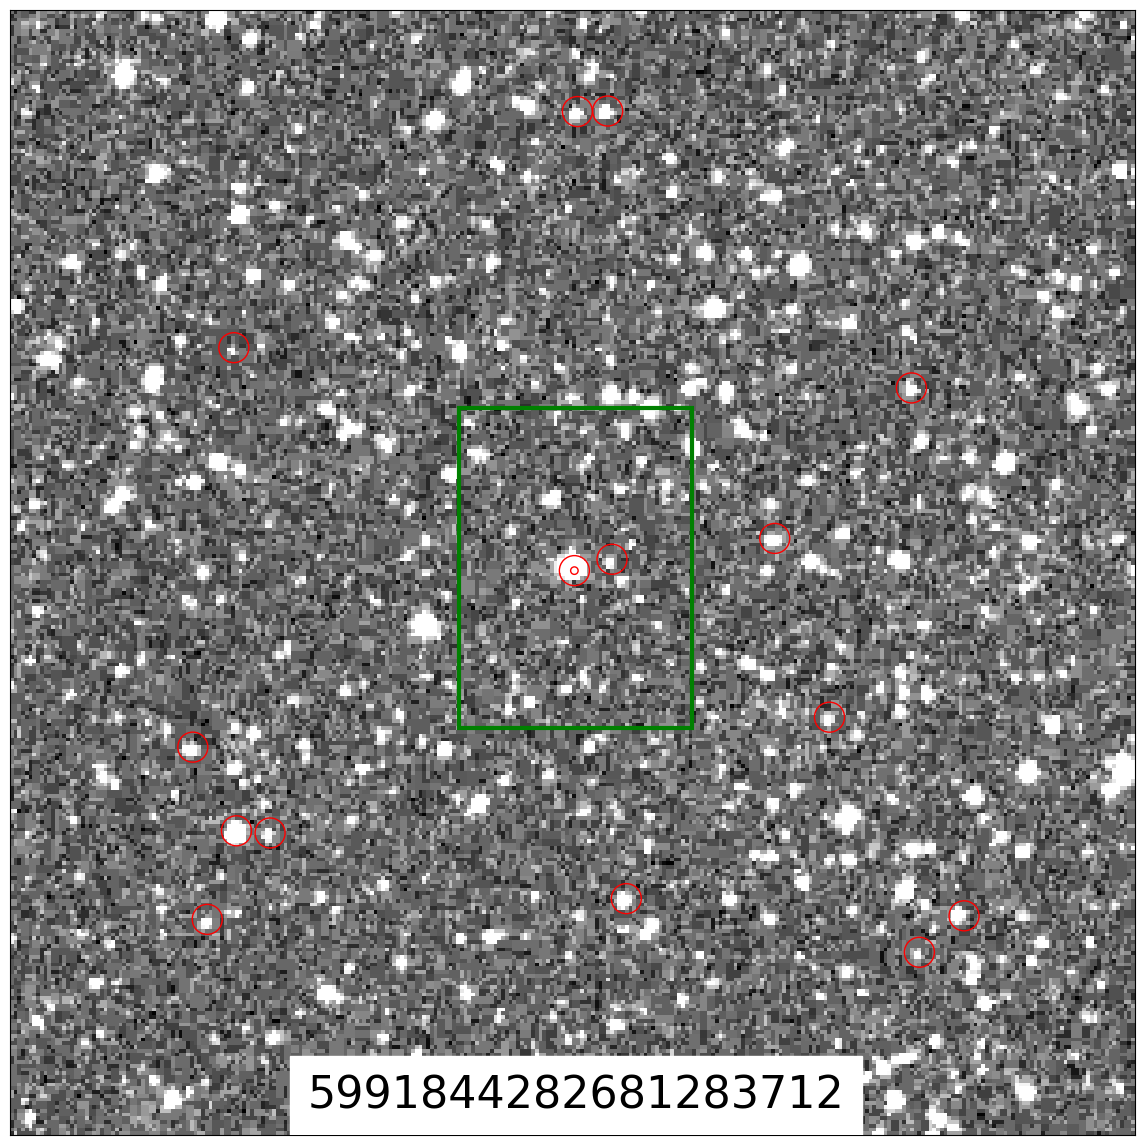

In [39]:
def ellipse_plot(x, y, size, a, b, theta, f_colour, e_colour):
    """
    Function to plot an ellipse on a CCD image.

    Keyword arguments:
    x           -- x-axis pixel coordinate centre of ellipse
    y           -- y-axis pixel coordinate centre of ellipse
    a           -- semi-major axis of ellipse
    b           -- semi-minor axis of ellipse
    f_colour    -- facecolour of ellipse
    e_colour    -- edge colour of ellipse
    number      -- number of ellipses to plot
    """

   
    e = Ellipse(xy=(x, y), width=2.*size*a, height=2.*size*b,
                    angle=theta * 180. / np.pi)
    e.set_facecolor(f_colour)
    e.set_edgecolor(e_colour)
    ax.add_artist(e)
    plt.draw()


# plot 'first' image
fig3, ax = plt.subplots(figsize=(15, 15), num=3)
plt.subplots_adjust(left=0.15, right=0.9, top=0.95, bottom=0.15)
m, s = np.mean(red_image), np.std(red_image)
im = ax.imshow(red_image, interpolation='nearest',cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
#tick_plot(ax, red_image[0], red_image[1])  # call tick function
#ax.grid(which='major', color='y', linestyle='-', linewidth=0.5)

ellipse_plot(xlength/2.0, ylength/2.0,2,2,2,0, 'none', 'red')
ellipse_plot(xlength/2.0, ylength/2.0,1,1,1,0, 'none', 'red')

rect = Rectangle((shoc_x, shoc_y), shoc_width, shoc_height, linewidth=3, edgecolor='g', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

mytext = mpl_text.Text(x=xcenpix, y = 10
            ,text=my_gaia_id
            ,color='black'
            ,backgroundcolor='white'
            ,verticalalignment='center'
            ,horizontalalignment='center'
            ,multialignment=None
            ,fontsize=32
            ,linespacing=None
            ,rotation_mode=None
        )
ax.add_artist(mytext)


for index, row in df_mookodi.iterrows():
    xx = row['xpix']
    yy = row['ypix']
    ellipse_plot(xx, yy,2,2,2,0, 'none', 'red')

# removing axes
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# saving the edited figure
plt.savefig('DR3_' + str(my_gaia_id) + '.png')


## Examine the image
Note that in this sample image, there are a number of bright stars close to our target star, which might make for a good set of comparison stars.  In this case, I would go take a look at all of the stars which have good photometry and see if it makes sense to alter the brightness cutoff in order to have some bright comparison stars.  Take a look and input the number of bright stars that have good photometry.  Should you change the brightness limit? Explain. The image also has a few comparison stars circled which are unlikely to be good comparison stars.  Which stars are they?  Why don't we want them as comparison stars?

## Your answer here:

## Optional: Use ds9 to display the image.
I am not sure I like the looks of the gray scale image, so I also played around with the image in ds9.  
We first need to create a region file with all of the stars circled, and the name of our target star at the bottom of the image.


In [40]:
f = open("region.reg", "w")
f.write("physical; text(150,10 ) # color=green font=\"times 16 bold \" text={DR3 " + str(my_gaia_id) + "}\n")

f.write("global color=blue dashlist=8 3 width=4\n")
f.write("fk5\n")

new_ra = str(df['raj2000'].iloc[0])
new_dec= str(df['dej2000'].iloc[0])
f.write("circle(" + new_ra + "," + new_dec + ", 0.0014)\n")



f.write("global color=green dashlist=8 3 width=2\n")


for index, row in df_mookodi.iterrows():
    new_ra = str(row['raj2000'])
    new_dec= str(row['dej2000'])
            
    if (row['dist'] >= 0.0233 ) : 
        f.write("circle(" + new_ra + "," + new_dec + ", 0.0014)\n")

f.write("global color=red dashlist=8 3 width=3\n")
for index, row in df_shoc.iterrows():
    new_ra = str(row['raj2000'])
    new_dec= str(row['dej2000'])
            
    f.write("circle(" + new_ra + "," + new_dec + ", 0.0014)\n")


f.close()

#open and read the file after the overwriting:
#f = open("region.reg", "r")
# print(f.read())

## Startup ds9 and circle the stars
Note that the location of the ds9 application hardwired into the code.  This worked fine on my Mac, where I have ds9 installed natively.  You will have to change this if you are running on a virtual machine, or Jhub, or launch ds9 manually, reeading in the fits file and the region file.  

In [41]:
# from subprocess import Popen
# exe="C:/Users/Aryan Bawa/AppData/Roaming/Microsoft/Windows/Start Menu/Programs"
# #ifile="output.fits"
# args=[exe,file_name,"-region", "region.reg", "-zoom", "to", "fit"]
# Popen(args)

# permission error cause windows :(

## Priority Class & instrument
Once you are satisified that you have the correct brightness limits, and so your final sample of comparison stars, you need to assign a priority class to this star, ranging from 1 (must observe) to 4 (do not observe).  Append this priority class column to your input csv file of target stars (RRLyr?.csv).  In adition, append a column which indicates if this target can be observed with SHOC (and its much smalle field of view).  The name of this column should be 'SHOC' and with boolean values (True or False).  Finally, append a colomn with the RA  in hours, minutes and seconds (hint: astropy has utilities to do this conversion). Why do we want this column? 

## Write out the Good comparison stars
Output (as a csv file)  RA and Dec and the g and i magnitudes (including their errors) of the target and comparison stars.    Order the comparison stars by distance from the target star.  Use the Gaid ID of the target star as the name of the output file, and for the target star, have the last column be its Gaia ID. 

In [42]:
# assigning priority class
df_mookodi['Priority'] = 2
df_mookodi['SHOC'] = False

C:\Users\Aryan Bawa\AppData\Local\Temp\ipykernel_27204\1929679903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mookodi['Priority'] = 2
C:\Users\Aryan Bawa\AppData\Local\Temp\ipykernel_27204\1929679903.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mookodi['SHOC'] = False
